# Homework10

Exercises with text processing and NLP modeling

## Goals

- Understand similarities and differences between the processes of working with text, images and tabular data
- Practice with different methods of encoding and modeling text data
- See different methods for extracting information or patterns from text datasets

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/text_utils.py

In [34]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import math

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from data_utils import display_silhouette_plots, object_from_json_url
from text_utils import get_top_words

You can tell it's gonna be a good homework from the number of imports.
# 🙃

## Have protein, need seasoning

Let's create a model to help us season our foods. In the end, what we want is a model that receives a short list of ingredients and returns a list of seasonings or complementary ingredients for our original ingredients list.

In order to do that we need a dataset of recipes. We'll load that into a text dataset where each recipe is a document and the ingredients are our document *tokens*.

Let's take a look at the recipe dataset and become familiar with the data and how it's organized.

We'll load our recipes and do a bit of exploratory data analysis to look for patterns first to see if this kind of modeling makes any sense.

### Load Data

Here's our dataset. Let's load it into an object for inspection:

In [35]:
DATAPATH = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/refs/heads/main/datasets/text/recipes"
recipes_obj = object_from_json_url(f"{DATAPATH}/recipes_min16.json")

### Look at Data

How's the data organized?

How many recipes do we have?

Do all recipes have the same number of ingredients?

Anything else stand out about the data?

In [36]:
# TODO: Look at Data here
for recipe in recipes_obj[:3]:
    print(recipe)
    print()

# TODO: How many recipes
num_recipes = len(recipes_obj)
print("Number of recipes:", num_recipes)

# TODO: How many ingredients do the shortest and longest recipes have?
ingredient_counts = [len(recipe["ingredients"]) for recipe in recipes_obj]

shortest = min(ingredient_counts)
longest = max(ingredient_counts)

print("Shortest recipe:", shortest, "ingredients")
print("Longest recipe:", longest, "ingredients")


{'id': 18009, 'ingredients': ['raisins', 'baking powder', 'egg', 'sugar', 'milk', 'flour']}

{'id': 35687, 'ingredients': ['parmesan cheese', 'salt', 'cornmeal', 'black pepper', 'sausage', 'olive oil', 'leeks', 'water']}

{'id': 38527, 'ingredients': ['salt', 'corn starch', 'butter', 'lemon juice', 'baking powder', 'heavy cream', 'peaches', 'sugar', 'flour']}

Number of recipes: 5015
Shortest recipe: 5 ingredients
Longest recipe: 27 ingredients


### Create Input Features

Our dataset doesn't really have to be a `DataFrame` here. It can, but it doesn't have to be.

Each recipe right now is described as a list of ingredients, but what we really want is a list of *sentences*, where each *sentence* is a Python `string` with all of the ingredients for a given recipe.

Instead of:<br>```["salt", "baking soda", "water", "mushroom"]```,

we want:<br>```"salt baking soda water mushroom"```

The `join()` function might help.

Another thing to consider is wether we want to do anything special about multi-word ingredients, like *baking soda*.

Do we want to let our vectorizer (spoiler) split that into two tokens, or do we want to guarantee that *baking* and *soda* always stay together? 

In [37]:
# TODO: turn list of objects into list of strings
sentences = [' '.join(ing.replace(' ', '_') for ing in recipe["ingredients"]) for recipe in recipes_obj]
print(sentences)

['raisins baking_powder egg sugar milk flour', 'parmesan_cheese salt cornmeal black_pepper sausage olive_oil leeks water', 'salt corn_starch butter lemon_juice baking_powder heavy_cream peaches sugar flour', 'corn_starch orange_juice rice ginger vinegar vegetable_oil garlic sriracha sesame_seeds chicken_broth soy_sauce egg onion white_pepper orange_zest sugar', 'cilantro rice ginger garlic yogurt curry_powder onion cumin', 'mozzarella_cheese salt parmesan_cheese rice pasta marinara_sauce basil', 'salt rice chili olives jack_cheese cheddar_cheese water sour_cream', 'salt rice vegetable_oil egg cold_water buttermilk flour', 'salt turmeric rice butter water', 'salt potatoes shallots vinegar lentils black_pepper parsnips chicken_broth carrots olive_oil bay celery', 'salt parmesan_cheese wine rice butter bacon shallots potatoes herbs pepper garlic nutmeg olive_oil paprika vegetable_stock', 'lime lemongrass hot_water fish_sauce chili serrano_pepper ginger garlic coriander basil mint scallion

### Encode Data

The fun part.

Let's vectorize our list of ingredient strings into a sparse document matrix using `CountVectorizer` or `TfidfVectorizer`.

The resulting matrix will have one row for each recipe, and the columns will encode the ingredients.

In [38]:
# TODO: Vectorize ingredients from our recipe list
mVec = TfidfVectorizer()
recipes_vct = mVec.fit_transform(sentences)
# TODO: How many words are in our vocabulary?
vocab = mVec.get_feature_names_out()
print(len(vocab))



520


### Cluster Data

Now that we have our recipes/documents vectorized we can study them a little bit, and look for patterns.

What happens if we cluster our recipes ? What do the cluster centers represent ?

When might this be useful ?

In [39]:
# TODO: cluster recipes
mClust = KMeans(n_clusters=6, random_state=800)
recipes_km = mClust.fit_predict(recipes_vct)

### Cluster Centers

Use the `get_top_words()` function to decode the `cluster_centers` back into ingredients.

In [40]:
# TODO: Look at cluster centers
mClust.cluster_centers_

array([[0.00263279, 0.        , 0.00414739, ..., 0.00187588, 0.03685148,
        0.00693174],
       [0.        , 0.        , 0.        , ..., 0.00319098, 0.        ,
        0.00904362],
       [0.00063426, 0.        , 0.00439759, ..., 0.0021289 , 0.00834486,
        0.00746427],
       [0.00476821, 0.00691839, 0.        , ..., 0.00451485, 0.00255685,
        0.02053081],
       [0.00451901, 0.00233096, 0.00049426, ..., 0.00420582, 0.010544  ,
        0.00879537],
       [0.00775412, 0.00477826, 0.        , ..., 0.        , 0.00749643,
        0.00036066]], shape=(6, 520))

### Interpretation

<span style="color:hotpink">
What do these cluster centers represent ?<br>
Is there anything interesting about recipe cluster centers ?<br>
</span>

<span style="color:hotpink;"> I chose 8 clusters, just a random guess, and I assume that the recipes are getting clustered depending on the similarities of the ingredients. I want to take a look. </span>

In [41]:
get_top_words(mClust.cluster_centers_, vocab, 6)[0]

[['cilantro', 'chili', 'onion', 'garlic', 'salt', 'ginger'],
 ['soy_sauce', 'sesame_oil', 'ginger', 'sugar', 'garlic', 'vinegar'],
 ['tortilla', 'sour_cream', 'chili', 'cilantro', 'cheddar_cheese', 'onion'],
 ['parmesan_cheese', 'basil', 'olive_oil', 'garlic', 'tomatoes', 'salt'],
 ['olive_oil', 'salt', 'onion', 'garlic', 'black_pepper', 'parsley'],
 ['flour', 'egg', 'sugar', 'butter', 'milk', 'salt']]

<span style="color:hotpink;"> Yep, I can see categories, like italian, asian, baking (sweet and savory), two categories of Mexican, and dishes with peas, ham, etc. </span>

### Plot Clusters

Let's plot our clusters to see if we have to adjust any of the clustering parameters.

Since we can't plot in $500$ dimensions, we should use `TruncatedSVD` to look at our clusters in $2D$ and $3D$.

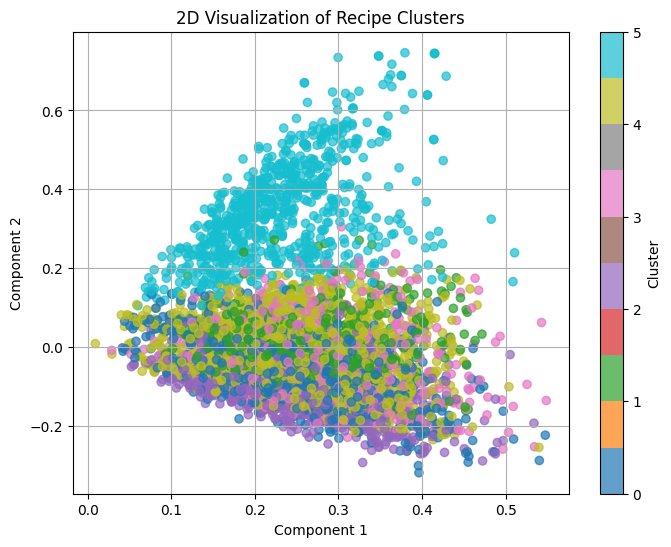

In [42]:
# TODO: TruncatedSVD to reduce the dimensions of our feature space
svd_2d = TruncatedSVD(n_components=2, random_state=800)
recipes_2d = svd_2d.fit_transform(recipes_vct)
# TODO: plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(recipes_2d[:, 0], recipes_2d[:, 1], c=recipes_km, cmap='tab10', alpha=0.7)
plt.title("2D Visualization of Recipe Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

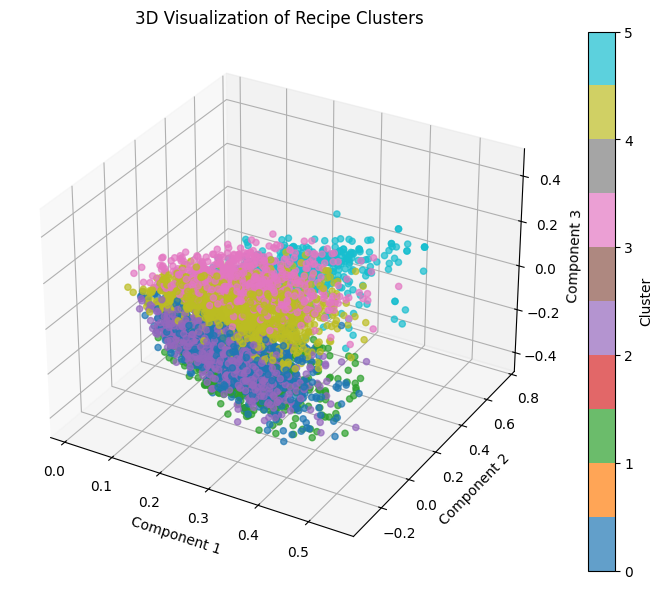

In [43]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3 dimensions
svd_3d = TruncatedSVD(n_components=3, random_state=800)
recipes_3d = svd_3d.fit_transform(recipes_vct)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(recipes_3d[:, 0], recipes_3d[:, 1], recipes_3d[:, 2], c=recipes_km, cmap='tab10', alpha=0.7)

ax.set_title("3D Visualization of Recipe Clusters")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
fig.colorbar(scatter, ax=ax, label="Cluster")
plt.show()

### Interpretation

<span style="color:hotpink">
What does the graph look like ?<br>
Are the clusters well-separated ?
</span>

<span style="color:hotpink;">I can see some clusters that are well separated, while others seem to represent the same category and are mixed (like the two types of Mexican or baking). I think I can probably reduce the clusters to "force" those two categories to merge and create better defined clusters. I did and ended up with 5 clusters for better definition.</span>

### Plot Silhouette Plots

We can also check the quality of our clustering by looking at the silhouette plots that we get from calling:<br>
`display_silhouette_plots(vectors, clusters)`.

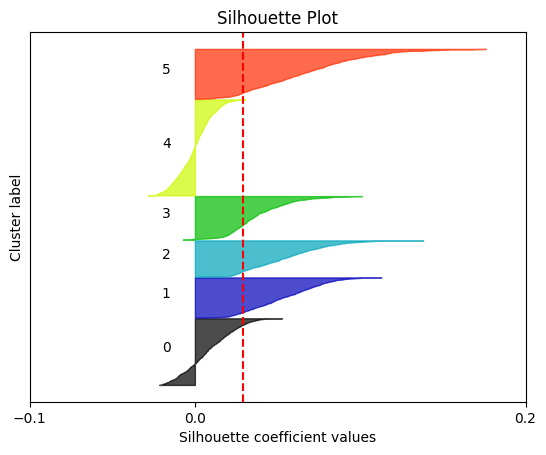

In [44]:
display_silhouette_plots(recipes_vct, recipes_km)

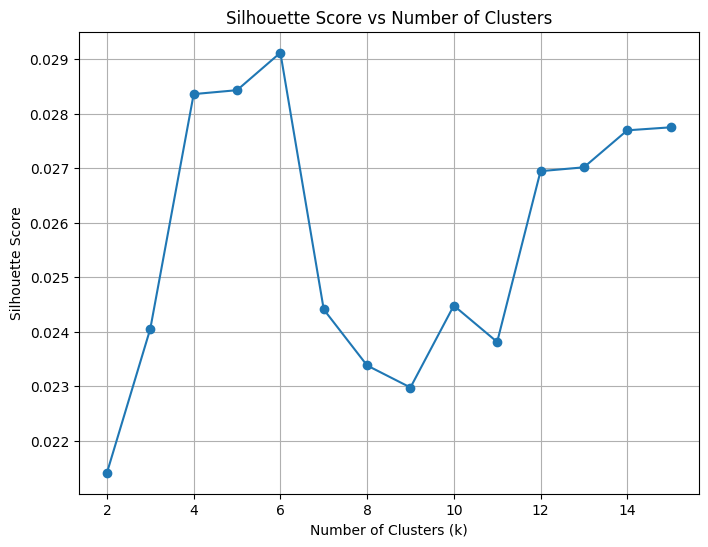

In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []
k_values = range(2, 16)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=800)
    labels = kmeans.fit_predict(recipes_vct)
    score = silhouette_score(recipes_vct, labels)
    silhouette_scores.append(score)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

### Interpretation

<span style="color:hotpink">
How many clusters did you end up with ?<br>
How do they look ?<br>
</span>

<span style="color:hotpink;">I ended up with 5, which look better defined, but when I analyzed, it seems that 6 is the best number of clusters. I will run it again. </span>

## Recipe Completion

Ok. On to the main event.

Let's create some recipes.

We'll do this using a technique similar to what is used for movie/product recommendations. Given an initial set of ingredients, we'll look at recipes that have similar ingredients and "recommend" additional ingredients.

We already have all of the recipes in our dataset encoded as `tf-idf` vectors. The rest of our algorithm will be something like:
1. Start with an initial set of ingredients
2. Encode ingredients
3. Find a set of recipes that are similar to our list of ingredients
4. Find common ingredients that are in the similar recipes, but not in our list of ingredients
5. Pick representative ingredient to add to recipe
6. Repeat

Let's start.

### 1. Initial list of ingredients

This is just a string with ingredients:

In [59]:
recipe_seed_str = "tofu" # feel free to change this
recipe_seed_str += f" soy_sauce"

print("Updated recipe:", recipe_seed_str)

Updated recipe: tofu soy_sauce


### 2. Encode ingredients

Transform the string into a `tf-idf` vector:

In [60]:
# TODO: transform string into sparse vector

recipe_seed_vct = mVec.transform([recipe_seed_str])


### 3. Find similar recipes

The meat of the algorithm. No pun intended.

In order to find similar recipes, we'll first calculate the distance between our current list of ingredients and all recipes in our dataset.

We can start with euclidean distance and later try other kinds, but the overall processing will be the same:

1. Start with an empty list to store distances
2. Loop over the `tf-idf` recipe vectors and for each vector:
   1. Subtract the ingredient list
   2. Square the difference (to square a sparse matrix `A`, use `A.multiply(A)`)
   3. Sum the terms of the result
   4. Take the square root of the sum
   5. Append to distance list
3. Find the indices of the smallest distances (this operation is called `argsort` and will give us the indices of the recipes that are most similar to our list of ingredients)
4. Check the recipes to see if they are indeed similar (`inverse_transform()` the vectors at the indices calculated above)

In [61]:
# argsort a list (get sequence of indices that would sort the list)
# https://stackoverflow.com/a/3382369
def argsort(L, reverse=False):
  return sorted(range(len(L)), key=L.__getitem__, reverse=reverse)

In [62]:
# TODO: list to keep distances
recipe_dists = []

# TODO: loop over vectors and append euclidean distances to list
for i in range(recipes_vct.shape[0]):
    vec = recipes_vct[i]
    diff = vec - recipe_seed_vct         # subtract the ingredient vector
    sq_diff = diff.multiply(diff)        # square the sparse matrix
    sum_sq = sq_diff.sum()               # sum the squared terms
    dist = math.sqrt(sum_sq)             # square root
    recipe_dists.append(dist)

# TODO: argsort list of distances to find indices of similar recipes
def argsort(L, reverse=False):
    return sorted(range(len(L)), key=L.__getitem__, reverse=reverse)

nearest_idxs = argsort(recipe_dists)

# TODO: check first 4 
closest_recipes = recipes_vct[nearest_idxs[:4]]
mVec.inverse_transform(closest_recipes)

[array(['sugar', 'garlic', 'sesame_seeds', 'soy_sauce', 'scallions',
        'red_pepper', 'sesame_oil', 'tofu'], dtype='<U27'),
 array(['black_pepper', 'rice', 'vinegar', 'vegetable_oil', 'soy_sauce',
        'onion', 'carrots', 'toasted_sesame_oil', 'tofu'], dtype='<U27'),
 array(['olive_oil', 'lemon_juice', 'ginger', 'soy_sauce', 'honey', 'tofu',
        'wheat_flour'], dtype='<U27'),
 array(['water', 'soy_sauce', 'onion', 'chili', 'pepper', 'chicken_stock',
        'black_bean', 'pork', 'tofu'], dtype='<U27')]

### 4. Find ingredients to recommend

We have a way to get a set of similar recipes with similar ingredients, and now want to find a *meaningful*, or *representative*, ingredient to add to our ingredients list.

Let's consider ingredients in the $16$ most similar recipes. What we are trying to do is find an ingredient that is in a lot of these recipes, but not yet in our list of ingredients.

There are many possible ways of doing this. We could count the number of times different ingredients show up in these $16$ recipes using Python dictionaries and/or sets, but what we're trying to do here is very similar to what a `TfidfVectorizer` does: calculate relative importance of terms in a series of documents.

Let's re-encode these $16$ recipes using their own separate `TfidfVectorizer`, then sum the importance of each ingredient and look at ingredients with the highest importance scores.

We could re-use the vectors/scores from the original `TfidfVectorizer`, but they're gonna be influenced by the relative frequencies of all of the ingredients that showed up in all of the recipes. Using a separate vectorizer is a little bit more precise.

The steps we need to take are:

1. Separate the $16$ recipes most similar to our list of ingredients
   1. We have lots of representations of our recipes, but `recipes` (list of strings) might be the easiest one to use here
2. Create a new `TfidfVectorizer` and encode the $16$ recipes
3. Sum the resulting vectors to get overall importance scores for each ingredient/token
4. Convert resulting vector to a list using `A.tolist()[0]`
5. `argsort` the importance scores to get sequence of ingredient indices ordered from most to least important
6. Find the most important ingredient that isn't on the ingredient list

In [63]:
# TODO: Get 16 most similar recipes
top_similar_idxs = nearest_idxs[:16]
top_similar_recipes = [sentences[i] for i in top_similar_idxs]

# TODO: Encode the 16 recipes
localVec = TfidfVectorizer()
local_vct = localVec.fit_transform(top_similar_recipes)

# TODO: Sum the recipe vectors by column to get ingredient importance scores
ingredient_scores = local_vct.sum(axis=0)

# TODO: Convert sparse vector to regular list with A.tolist()[0]
ingredient_scores_list = ingredient_scores.tolist()[0]

# TODO: argsort the importance scores
important_ingredient_idxs = argsort(ingredient_scores_list, reverse=True)

# TODO: Find most important ingredient not yet on the list of ingredients
current_ingredients = recipe_seed_str.split()
recommended_ingredient = None

for idx in important_ingredient_idxs:
    token = localVec.get_feature_names_out()[idx]
    if token not in current_ingredients:
        recommended_ingredient = token
        break

print(f"Recommended ingredient: {recommended_ingredient}")

Recommended ingredient: onion


### 5. Add ingredient to recipe

This is simply adding a word to `recipe_seed_str`

In [64]:
# TODO: add the first important ingredient to list of ingredients

recipe_seed_str += f" {recommended_ingredient}"

print("Updated recipe:", recipe_seed_str)


Updated recipe: tofu soy_sauce onion


### 6. Repeat (Optional)

Now we can repeat this process until we get an empty list of important ingredients: 
1. Encode current recipe
2. Find similar recipes
3. Find important ingredients
4. Add important ingredient

Might be helpful to define a couple of functions, like `find_similar_recipes()` and `find_important_ingredients()`...

Only do this step if you're really curious about experimenting with generating unconventional ingredient lists. It's not going to be graded.

In [ ]:
# TODO: Create find_similar_recipes(ingredients, recipes, vectorizer)

# TODO: Create find_important_ingredients(recipes)

# TODO: Create recipe by repeating calls to find_similar_recipes() and find_important_ingredients()